# Marker detection

-  Next step: result per top

In [1]:
import pandas as pd

df_logs = pd.read_parquet("data/Training/logs.parquet")
df_loc = pd.read_parquet("data/Training/loc.parquet")
df_tops = pd.read_parquet("data/Training/tops.parquet")

In [2]:
# df_logs contains for each well (indexed by well name), the depths and the GR
df_logs

,wellName,DEPTH,GR
1,512320698.0,421.0,96.9752
2,512320698.0,421.5,102.3324
3,512320698.0,422.0,104.6432
4,512320698.0,422.5,99.2187
5,512320698.0,423.0,92.0200
...,...,...,...
9650828,512336327.0,7187.5,780.6628
9650829,512336327.0,7188.0,798.1260
9650830,512336327.0,7188.5,808.1805
9650831,512336327.0,7189.0,810.6509


In [3]:
# df_loc contains the location of each well
df_loc

,Latitude,Longitude
wellName,,
512320698.0,48.673353,2.145178
512320699.0,48.673353,2.150808
512320928.0,48.698713,2.140728
512320970.0,48.713273,2.150148
512320971.0,48.709603,2.145308
...,...,...
512334042.0,48.655583,2.221548
512334043.0,48.655623,2.221548
512335135.0,48.651423,2.216608


In [4]:
# df_tops contains for each well name, the depth of the markers
df_tops

,MARCEL,CONRAD,SYLVAIN
wellName,,,
512320698.0,6398.0,6661.0,6638.0
512320699.0,6407.0,6676.0,6656.0
512320928.0,6520.0,6793.0,6746.0
512320970.0,6544.0,6816.0,6770.0
512320971.0,6510.0,6789.0,6742.0
...,...,...,...
512334042.0,6264.0,6524.0,6500.0
512334043.0,6259.0,6526.0,6502.0
512335135.0,6684.0,6938.0,6914.0


In [5]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

#import plotly.plotly as pyl
from chart_studio import plotly as pyl

top = "CONRAD"

df_loc[top] = df_tops[top]
data = [ dict(
        type = 'scattergeo',
        lon = df_loc['Longitude'],
        lat = df_loc['Latitude'],
        text = df_loc[top],
        mode = 'markers',
        marker = dict(
            color = df_loc[top],
        )
        )]

layout = dict(
        title = '{0} Depth information<br>(Hover for depth info)'.format(top),
        colorbar = True,
        geo = dict(
            scope='europe',
            projection=dict( type='natural earth',scale=100 ),
            center = dict( lon=df_loc["Longitude"].mean(), lat = df_loc["Latitude"].mean()),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 1.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=data, layout=layout )
iplot( fig, validate=False, filename='niobrara' )

In [6]:
wellist = df_tops.index.tolist()

layout = go.Layout(
    height=120,
    margin=go.layout.Margin(
        l=50,
        r=50,
        b=20,
        t=0,
        pad=4
    )
)

def plot_pred(wellname,top_name,wsize):
    df_temp = df_logs[df_logs["wellName"]==wellname]

    true_top = df_tops.loc[wellname][top_name]
    if true_top > 0:
        ctr = df_temp[df_temp["DEPTH"]==true_top].index[0]
        true_log = df_temp.loc[ctr-wsize:ctr+wsize]

        bar = go.Bar( x = [true_top],y = [ df_temp["GR"].max()  ],name = top, width = 1)
        data = [go.Scatter(x=true_log.DEPTH,y=true_log.GR),bar]
  
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)
    
for well in wellist[0:10]:  
    plot_pred(well,top,100)

In [7]:
from hacktops.evaluate import recall_tops

recall, mae, df_res = recall_tops(df_tops,df_tops,tolerance = 10)
print("recall {0}, mae {1}".format(recall,mae))
df_res


recall 1.0, mae 0.0


,MARCEL,CONRAD,SYLVAIN,MARCEL_pred,CONRAD_pred,SYLVAIN_pred,MARCEL_ae,MARCEL_tp,CONRAD_ae,CONRAD_tp,SYLVAIN_ae,SYLVAIN_tp
wellName,,,,,,,,,,,,
512320698.0,6398.0,6661.0,6638.0,6398.0,6661.0,6638.0,0.0,True,0.0,True,0.0,True
512320699.0,6407.0,6676.0,6656.0,6407.0,6676.0,6656.0,0.0,True,0.0,True,0.0,True
512320928.0,6520.0,6793.0,6746.0,6520.0,6793.0,6746.0,0.0,True,0.0,True,0.0,True
512320970.0,6544.0,6816.0,6770.0,6544.0,6816.0,6770.0,0.0,True,0.0,True,0.0,True
512320971.0,6510.0,6789.0,6742.0,6510.0,6789.0,6742.0,0.0,True,0.0,True,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
512334042.0,6264.0,6524.0,6500.0,6264.0,6524.0,6500.0,0.0,True,0.0,True,0.0,True
512334043.0,6259.0,6526.0,6502.0,6259.0,6526.0,6502.0,0.0,True,0.0,True,0.0,True
512335135.0,6684.0,6938.0,6914.0,6684.0,6938.0,6914.0,0.0,True,0.0,True,0.0,True


In [8]:
# Model: DTW --> not good results
# Noisy labels (error in the annotation): clustering of signature, selection of the highest density cluster; 
# 2 tricks
#  -  window size fixed (+- 50 --> 101 points) --> cluster (LSTM) --> sort of signature by density 
# --> 10 signatures selected --> majority vote with DTW
#  -  on the signature: window size flexible for each marker
# 87 recall, mae not obvious (margin on the location)
# 600 wells training, 50 wells for testing (clean), then 100 wells (for score, very clean)

# Display of all the markers

In [9]:
wellist = df_tops.index.tolist()
top_list = ["MARCEL", "CONRAD", "SYLVAIN"]
wsize = 100

Progress: 0.0 %
Progress: 33.333333333333336 %
Progress: 66.66666666666667 %


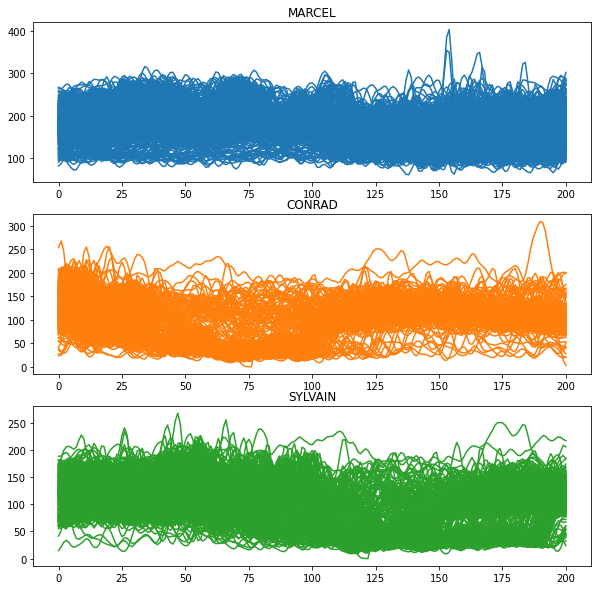

In [10]:
from matplotlib import pyplot as plt
import numpy as np
# Display of the logs 

def plot_pattern(wellname,top_name,wsize, ax, color):
    df_temp = df_logs[df_logs["wellName"]==wellname]

    true_top = df_tops.loc[wellname][top_name]
    if true_top > 0:
        
        #if wellname == 512323515.0:
            #print(true_top)
            #print(df_temp["DEPTH"].loc[1455200:1456000].values)
        
        if len(df_temp[df_temp["DEPTH"]==true_top])>0:
            ctr = df_temp[df_temp["DEPTH"]==true_top].index[0]
        else:
            #print(true_top)
            tol = 4
            mask1 = (df_temp["DEPTH"]>true_top-tol)
            mask2 = (df_temp["DEPTH"]<true_top+tol)
            diff = df_temp[mask1.values & mask2.values].copy()
            diff['DIFF'] = diff['DEPTH'] - true_top
            ctr = diff['DIFF'].idxmin()
            
        
        true_log = df_temp.loc[ctr-wsize:ctr+wsize]
        
        true_log_depth = true_log.DEPTH
        true_log_gr = true_log.GR
        
        if np.sum(true_log_gr.values<-8000)==0:
            ax.plot(true_log_gr.values, c = color)
        
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
colors = colors[:3]
for top_id, top in  enumerate(top_list):
    for well_id, well in enumerate(wellist):  
        #print(well)
        plot_pattern(well,top,wsize, ax[top_id], colors[top_id])
    print("Progress: " + str(100*top_id/3) + " %")
    ax[top_id].set_title(top)

# Training 

In [11]:
import scipy

def extract_pattern(wellname,top_name,wsize):
    df_temp = df_logs[df_logs["wellName"]==wellname]

    true_top = df_tops.loc[wellname][top_name]
    if true_top > 0:
        
        #if wellname == 512323515.0:
            #print(true_top)
            #print(df_temp["DEPTH"].loc[1455200:1456000].values)
        
        if len(df_temp[df_temp["DEPTH"]==true_top])>0:
            ctr = df_temp[df_temp["DEPTH"]==true_top].index[0]
        else:
            #print(true_top)
            tol = 4
            mask1 = (df_temp["DEPTH"]>true_top-tol)
            mask2 = (df_temp["DEPTH"]<true_top+tol)
            diff = df_temp[mask1.values & mask2.values].copy()
            #diff = df_temp.loc[mask1.values & mask2.values].copy()
            diff['DIFF'] = diff['DEPTH'] - true_top
            ctr = diff['DIFF'].idxmin()
            
        
        true_log = df_temp.loc[ctr-wsize:ctr+wsize]
        
        
        #true_log_depth = true_log.DEPTH
        true_log_gr = true_log.GR.values
        #true_log_gr_filter = scipy.ndimage.gaussian_filter(true_log_gr, sigma=5)
        
#         fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#         ax.plot(true_log_gr)
#         ax.plot(true_log_gr_filter)

        
        return true_log_gr, top_name
    
    else:
        
        return None, None

list_features = []
list_labels = []
for top_id, top in  enumerate(["MARCEL", "CONRAD", "SYLVAIN"]):
    for well_id, well in enumerate(wellist):  
        features, label = extract_pattern(well, top, wsize)
        
        if label is not None:
            if np.sum(features<-8000)>0: 
                continue
            list_features.append(features)
            list_labels.append(label)
            
    print("Progress: " + str(100*(top_id+1)/3) + " %")

Progress: 33.333333333333336 %
Progress: 66.66666666666667 %
Progress: 100.0 %


In [12]:
from scipy import signal

features_np = np.asarray(list_features)
labels_np = np.asarray(list_labels)

def compute_distance_matrix(top):

    mask = (labels_np == top)
    features_np_top =  features_np[mask,:]
    print(features_np_top.shape)

    distance_matrix = np.zeros((len(features_np_top), len(features_np_top)))
    shift_matrix = np.zeros((len(features_np_top), len(features_np_top)))
    
    iteration = 0
    for id1 in range(len(features_np_top)):

        for id2 in range(id1+1, len(features_np_top)):

            features1 = features_np_top[id1, :]
            features2 = features_np_top[id2, :]

            features1_norm = (features1 - np.mean(features1))/np.std(features1)
            features2_norm = (features2 - np.mean(features2))/np.std(features2)

            corr = signal.correlate(features1_norm, features2_norm, mode='same') 
            corr = corr/len(features1_norm)

            corr_max = np.max(corr)
            shift = np.argmax(corr) - int(0.5*len(features1_norm)+0.5)
            
            
            if shift>0:
                features1_new = np.copy(features1[shift:])
                features2_new = features2_norm[:len(features1_new)]
            else:
                features2_new = features2[-shift:]
                features1_new = features1[:len(features2_new)]
                
            diff = np.abs(features1_new-features2_new)
            distance = 1/len(diff)*np.sum(diff)
                
#             if (np.abs(shift)>5) & (corr_max>0.9):
#                 fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#                 ax.plot(corr)
                
#                 fig, ax = plt.subplots(1, 2, figsize=(5, 5))
#                 ax[0].plot(features1_norm)
#                 ax[0].plot(features2_norm)

#                 ax[1].plot(features1_norm_new)
#                 ax[1].plot(features2_norm_new)
#                 ax[1].set_title(shift)
            
            
    #         if corr_max>0.99:
    #             print(corr_max)
    #             fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #             ax.plot(features1_norm)
    #             ax.plot(features2_norm)

            distance_matrix[id1, id2] = distance#1-corr_max
            distance_matrix[id2, id1] = distance#1-corr_max
            shift_matrix[id1, id2] = shift
            shift_matrix[id2, id1] = shift

            iteration = iteration + 1

            if (iteration%10000 == 0):
                print("Progress: " + str(100*iteration/(0.5*len(features_np_top)*len(features_np_top))) + " %")    
                
    return distance_matrix, shift_matrix


distance_matrix_per_top = []
shift_matrix_per_top = []
for top in top_list:
    
    print(top)
    distance_matrix, shift_matrix = compute_distance_matrix(top)
    distance_matrix_per_top.append(distance_matrix)
    shift_matrix_per_top.append(shift_matrix)


MARCEL
(599, 201)
Progress: 5.574120473465793 %
Progress: 11.148240946931587 %
Progress: 16.72236142039738 %
Progress: 22.296481893863174 %
Progress: 27.870602367328964 %
Progress: 33.44472284079476 %
Progress: 39.01884331426055 %
Progress: 44.59296378772635 %
Progress: 50.16708426119214 %
Progress: 55.74120473465793 %
Progress: 61.315325208123724 %
Progress: 66.88944568158952 %
Progress: 72.4635661550553 %
Progress: 78.0376866285211 %
Progress: 83.6118071019869 %
Progress: 89.1859275754527 %
Progress: 94.76004804891848 %
CONRAD
(593, 201)
Progress: 5.687489513691209 %
Progress: 11.374979027382418 %
Progress: 17.062468541073628 %
Progress: 22.749958054764836 %
Progress: 28.437447568456047 %
Progress: 34.124937082147255 %
Progress: 39.81242659583847 %
Progress: 45.49991610952967 %
Progress: 51.18740562322088 %
Progress: 56.874895136912095 %
Progress: 62.5623846506033 %
Progress: 68.24987416429451 %
Progress: 73.93736367798572 %
Progress: 79.62485319167693 %
Progress: 85.31234270536814 %

MARCEL
Cluster -1 with num 349
Cluster 0 with num 174
Cluster 1 with num 37
Cluster 2 with num 13
Cluster 3 with num 2
Cluster 4 with num 4
Cluster 5 with num 5
Cluster 6 with num 6
Cluster 7 with num 9
CONRAD
Cluster -1 with num 47
Cluster 0 with num 524
Cluster 1 with num 22
SYLVAIN
Cluster -1 with num 155
Cluster 0 with num 17
Cluster 1 with num 348
Cluster 2 with num 17


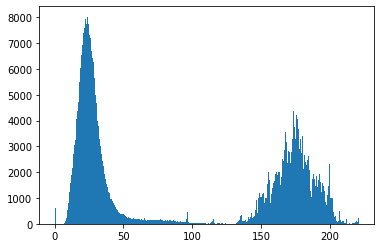

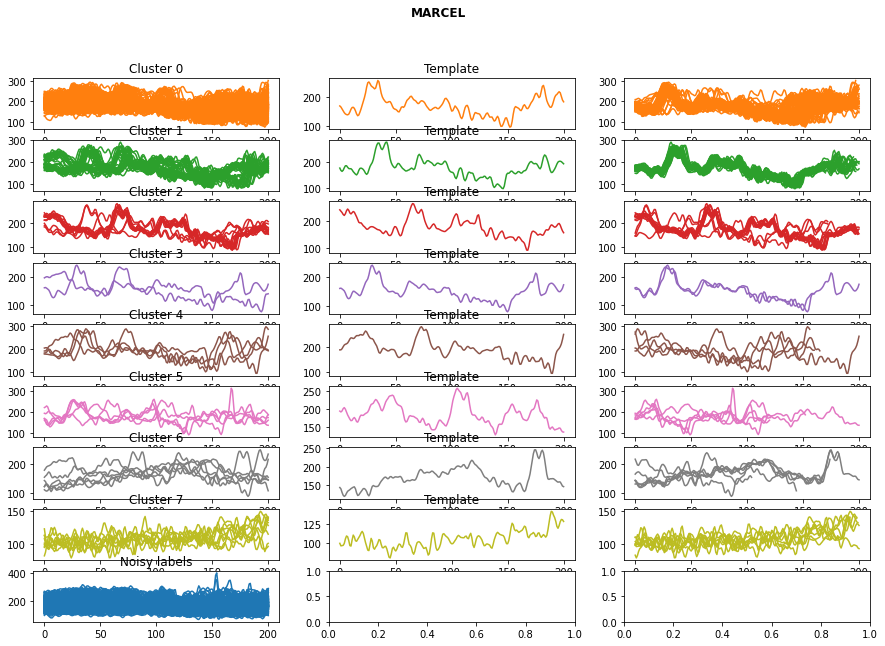

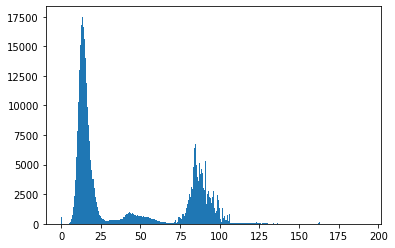

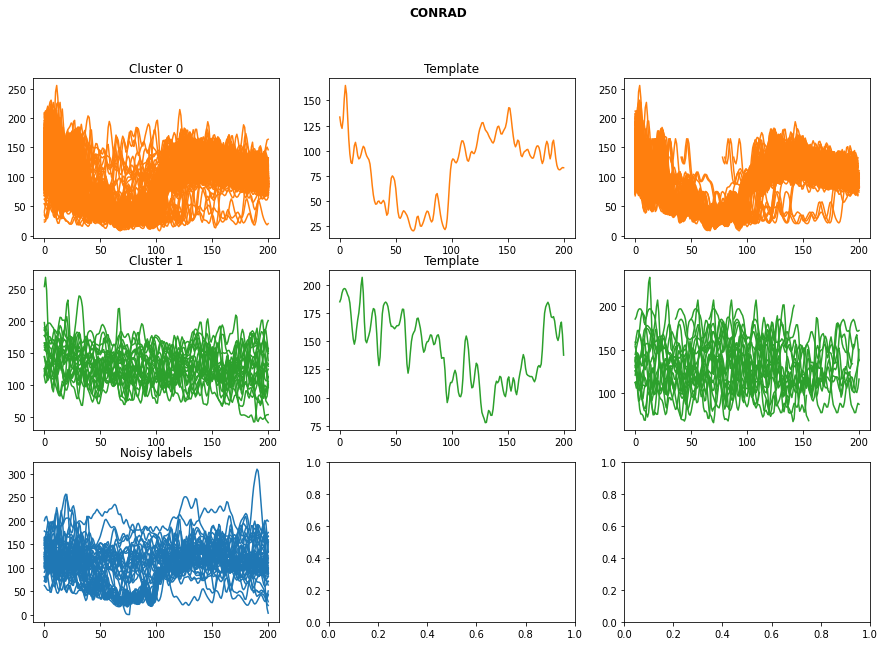

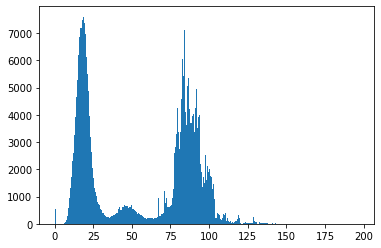

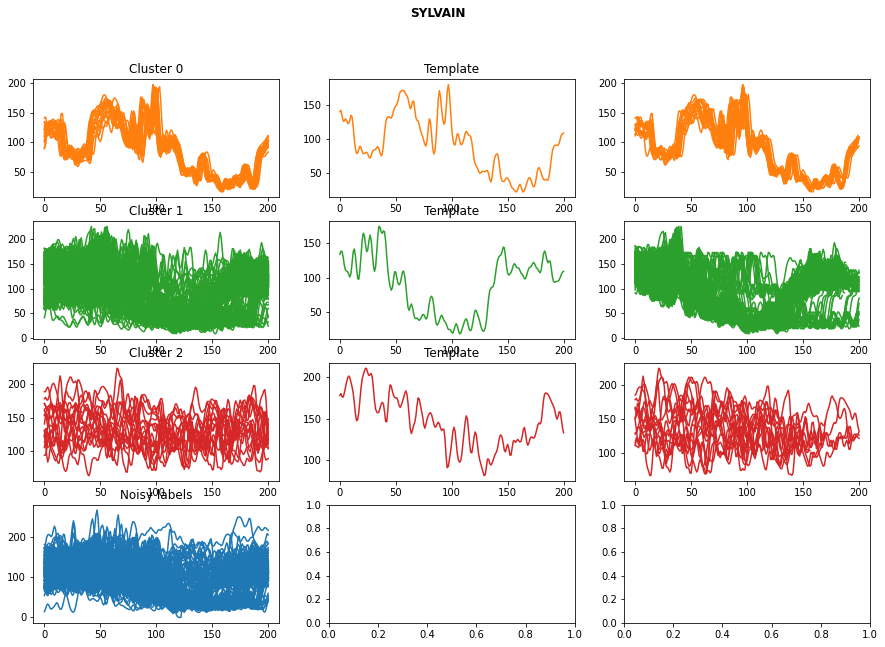

In [37]:
from sklearn.cluster import DBSCAN, OPTICS

def compute_clusters(top_id):
    
    top = top_list[top_id]

    print(top)
    
    template_list = []
    template_id = []
    
    distance_matrix = distance_matrix_per_top[top_id]
    
    fig, ax = plt.subplots(1, 1)
    ax.hist(distance_matrix.flatten(), bins=300)
    
    shift_matrix = shift_matrix_per_top[top_id]
    
    mask = (labels_np == top)
    features_np_top =  features_np[mask,:]
    
    #print(distance_matrix.shape)
    
    # MARCEL: eps=10, min_samples=5, template = 1 
    # CONRAD: eps=10, min_samples=5, template = 0 
    # SYLVAIN: eps=10, min_samples=5, template = 1  
    
    clustering = DBSCAN(eps=10., min_samples=5, metric='precomputed', n_jobs=-1).fit(distance_matrix)
    #clustering = OPTICS(min_samples=20, metric='precomputed', n_jobs=-1).fit(distance_matrix)
    
    #print(clustering.labels_)
    #print(clustering.core_sample_indices_)

    num_cluster = len(np.unique(clustering.labels_)) - 1
    #print(num_cluster)
    fig, ax = plt.subplots(num_cluster+1, 3, figsize=(15, 10))
    fig.suptitle(top,fontweight ="bold")

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colors = np.tile(colors, 10)

    
    for clustering_label in range(-1, num_cluster):

        mask_cluster = (clustering.labels_ == clustering_label)
        num_in_cluster = np.sum(mask_cluster)
        
        if num_in_cluster == 0: continue
        
        index_origin = np.where(mask_cluster)[0]
        
        feature_cluster = features_np_top[mask_cluster, :]
        
        
        #distance_cluster = distance_matrix[mask_cluster, mask_cluster]
        distance_cluster = distance_matrix[:, mask_cluster]
        distance_cluster = distance_cluster[mask_cluster, :]
        
        # a pattern is of high quality if it is closed to the majority of the other patterns
        pattern_quality = np.sum(distance_cluster, axis=0)
        
        #print(distance_cluster)
        #print(pattern_quality)
        
        index_template = np.argmin(pattern_quality)
        print("Cluster " + str(clustering_label) + " with num " + str(np.sum(mask_cluster)))
        
        for i in range(len(feature_cluster)):

            ax[clustering_label, 0].plot(feature_cluster[i, :], c=colors[clustering_label+1])
            if clustering_label == -1:
                ax[clustering_label, 0].set_title("Noisy labels")
            else:
                ax[clustering_label, 0].set_title("Cluster " + str(clustering_label))
                # shift of the log to check
                features1 = feature_cluster[index_template, :]
                features2 = feature_cluster[i, :]
                shift = int(shift_matrix[index_origin[index_template], index_origin[i]])
        
                fill_value = np.nan
                num = len(features1)
                if shift>0:
                    features2_new = fill_value*np.ones(num)
                    features2_new[shift:] = features1[:num-shift]
                else:
                    features2_new = fill_value*np.ones(num) 
                    features2_new[:num+shift] = features2[-shift:]
                    
                ax[clustering_label, 2].plot(features2_new, c=colors[clustering_label+1])
                
                
        if clustering_label > -1:
            template_list.append(feature_cluster[index_template, :])
            template_id.append(index_origin[index_template])
            
            ax[clustering_label, 1].plot(feature_cluster[index_template, :], c=colors[clustering_label+1])
            ax[clustering_label, 1].set_title("Template")

            
    # test, to see if the template are closed to each other
#     print(len(template_list))
#     features1 = template_list[0]
#     features2 = template_list[1]
#     shift = int(shift_matrix[template_id[0], template_id[1]])
#     dist = distance_matrix[template_id[0], template_id[1]]
#     print("id1 : " + str(template_id[0]))
#     print("id2 : " + str(template_id[1]))
#     print("dist: " + str(dist))

#     if shift>0:
#         features1_new = np.copy(features1[shift:])
#         features2_new = features2[:len(features1_new)]
#     else:
#         features2_new = features2[-shift:]
#         features1_new = features1[:len(features2_new)]

#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].plot(features1)
#     ax[0].plot(features2)

#     ax[1].plot(features1_new)
#     ax[1].plot(features2_new)
        
    return template_list
                
        
template_list_per_top = []
for top_id in range(len(top_list)):
    template_list = compute_clusters(top_id)
    template_list_per_top.append(template_list)

In [38]:
# selection of the template
top_id = 0
template_id = 1
template_list_per_top[top_id] = [template_list_per_top[top_id][template_id]]

# ok
top_id = 1
template_id = 0
template_list_per_top[top_id] = [template_list_per_top[top_id][template_id]]

top_id = 2
template_id = 1
template_list_per_top[top_id] = [template_list_per_top[top_id][template_id]]

In [39]:
print(len(template_list_per_top))
print(template_list_per_top[0])

3
[array([175.8489, 166.9495, 163.2661, 167.4628, 176.9573, 184.6615,
       184.7785, 178.9475, 174.116 , 173.3741, 173.3865, 169.0928,
       162.2101, 157.3018, 152.5803, 149.7392, 155.6791, 167.2265,
       174.5547, 175.677 , 173.9061, 170.3247, 164.1205, 156.0238,
       151.8183, 156.5976, 168.9286, 181.8857, 189.8773, 196.844 ,
       209.3477, 228.5354, 248.617 , 263.0661, 271.3118, 271.5252,
       261.7533, 249.5711, 246.4006, 254.1245, 265.2486, 274.011 ,
       275.1657, 261.163 , 235.3345, 211.5246, 196.1969, 186.9361,
       180.8475, 176.9771, 179.3207, 187.766 , 193.7552, 192.5375,
       186.4528, 179.682 , 174.8908, 171.6122, 167.7135, 164.5948,
       165.3171, 167.6041, 169.2356, 172.4845, 175.8867, 173.9239,
       169.7511, 173.7628, 188.2861, 207.3266, 223.1721, 228.4464,
       223.0227, 213.7599, 203.6775, 194.3813, 192.5016, 198.3336,
       203.644 , 204.2501, 201.531 , 198.3045, 196.1284, 191.8803,
       186.0247, 185.5498, 190.4769, 194.4361, 194.5011, 19

# Inference

In [40]:
df_logs_val = pd.read_parquet("data/Validation/logs_100.parquet")
df_loc_val = pd.read_parquet("data/Validation/loc_100.parquet")
df_tops_val = pd.read_csv("data/Validation/tops_100.csv")

In [41]:
wellist_validation = df_tops_val["wellName"].tolist()

# Create the tops dataframe to output 
df_tops_pred = pd.DataFrame(index = wellist_validation,columns = top_list)
    
for well_id, wellname in enumerate(wellist_validation):  
    
    df_temp = df_logs_val[df_logs_val["wellName"]==wellname]
    ctr = df_temp.index[0] + wsize
    
    dist_per_top = []
    for top_id in range(len(template_list_per_top)):
        dist_per_top.append([])
        
    depths = []
        
    while ctr<df_temp.index[-1]-wsize:
        
        log = df_temp.loc[ctr-wsize:ctr+wsize].GR.values
        log_norm = (log - np.mean(log))/np.std(log)
        depth = df_temp['DEPTH'].loc[ctr]
       
        for top_id in range(len(template_list_per_top)):
            
            template_list = template_list_per_top[top_id]
            
            dist_min = np.infty
            for template in template_list:
                
                #template_norm = (template - np.mean(template))/np.std(template)
                #dist = signal.convolve(log_norm, template_norm, mode='valid') 
                #dist = dist[0]/len(template_norm)
                dist = np.linalg.norm(template-log)
                
                if dist<dist_min:
                    dist_min = dist
            
            dist_per_top[top_id].append(dist)
            
        depths.append(depth)
        ctr = ctr + 1

#     fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#     prop_cycle = plt.rcParams['axes.prop_cycle']
#     colors = prop_cycle.by_key()['color']
    for top_id in range(len(template_list_per_top)):
        index_top = np.argmin(dist_per_top[top_id])
        
        top_location_pred = depths[index_top]
        df_tops_pred[top_list[top_id]].loc[wellname] = top_location_pred 

#         ax.plot(depths, dist_per_top[top_id], label=top_list[top_id], c=colors[top_id])        
#         top_location = df_tops_val[df_tops_val["wellName"]==wellname][top_list[top_id]].values[0]
#         ax.plot([top_location, top_location], [200, 400], linewidth=5, c=colors[top_id])
#         ax.plot([top_location_pred, top_location_pred], [0, 200], linewidth=5, c=colors[top_id])
        
#         print(top_list[top_id])
#         print("depth pred: " + str(top_location_pred))
#         print("depth GT: " + str(top_location))
        
        
#     ax.set_title("Well name: " + str(wellname))
#     ax.legend()
    
    if (well_id%10 == 0):
        print("Progress: " + str(100*well_id+/len(wellist_validation)) + " %")     
        
        
    

Progress: 1.0 %
Progress: 11.0 %
Progress: 21.0 %
Progress: 31.0 %
Progress: 41.0 %


C:\Users\jkherroubi\AppData\Local\Temp\ipykernel_16260\1448827689.py:20: RuntimeWarning:

invalid value encountered in true_divide



Progress: 51.0 %
Progress: 61.0 %
Progress: 71.0 %
Progress: 81.0 %
Progress: 91.0 %


In [42]:
df_tops_val2 = df_tops_val.set_index("wellName")

In [43]:
from hacktops.evaluate import recall_tops2

name_per_top, mae_per_top, tp_per_top, df_res = recall_tops2(df_tops_val2,df_tops_pred,tolerance = 10)

print(name_per_top)
print(mae_per_top)
print(tp_per_top)

['MARCEL', 'CONRAD', 'SYLVAIN']
[4.49, 33.41, 39.655]
[0.97, 0.99, 0.98]


In [44]:
from hacktops.evaluate import recall_tops

recall, mae, df_res = recall_tops(df_tops_val2,df_tops_pred,tolerance = 10)
print("recall {0}, mae {1}".format(recall,mae))
df_res

recall 0.98, mae 25.851666666666667


,MARCEL,CONRAD,SYLVAIN,MARCEL_pred,CONRAD_pred,SYLVAIN_pred,MARCEL_ae,MARCEL_tp,CONRAD_ae,CONRAD_tp,SYLVAIN_ae,SYLVAIN_tp
wellName,,,,,,,,,,,,
512326026,6530.0,6818.0,6791.0,6532.0,6818.0,6801.0,2.0,True,0.0,True,10.0,True
512322735,6585.0,6871.0,6847.5,6589.0,6871.5,6855.0,4.0,True,0.5,True,7.5,True
512326909,6240.0,6499.0,6472.0,6236.0,6496.0,6477.0,4.0,True,3.0,True,5.0,True
512325828,6269.0,6529.0,6505.0,6266.5,6529.5,6510.5,2.5,True,0.5,True,5.5,True
512330519,6236.0,6494.0,6471.0,6237.0,6494.5,6477.5,1.0,True,0.5,True,6.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...
512322532,6338.0,6609.0,6583.0,6339.5,6610.0,6593.0,1.5,True,1.0,True,10.0,True
512323102,6508.0,6772.0,6746.0,6509.0,6772.0,6755.0,1.0,True,0.0,True,9.0,True
512330486,6414.5,6693.0,6669.0,6412.0,6693.5,6676.5,2.5,True,0.5,True,7.5,True


In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(df_res["MARCEL_ae"].values)
ax.set_title("MAE MARCEL")

fig, ax = plt.subplots(1, 1)
ax.hist(df_res["CONRAD_ae"].values, range=(0, 100))
ax.set_title("MAE CONRAD")

fig, ax = plt.subplots(1, 1)
ax.hist(df_res["SYLVAIN_ae"].values)
ax.set_title("MAE SYLVAIN")